# Install packages and download raw data

In [ ]:
!pip -qq install wfdb
!gdown -qq 1QjLJSRYea8AfZ-OFhBll791hVPDeUP5t
!unzip -qq mit-bih-arrhythmia-database-1.0.0.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 20.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


# Clone github repo that contains text files about record annotations

In [ ]:
!git clone https://github.com/Ohyoukillkenny/mit-bih.git

Cloning into 'mit-bih'...
remote: Enumerating objects: 104, done.
remote: Total 104 (delta 0), reused 0 (delta 0), pack-reused 104 (from 1)
Receiving objects: 100% (104/104), 182.45 MiB | 3.84 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Updating files: 100% (97/97), done.


# Open one record and plot it

In [ ]:
# Tutorial web: https://medium.com/@protobioengineering/how-to-get-heart-data-from-the-mit-bih-arrhythmia-database-e452d4bf7215
import wfdb

# Dataset contains patients in RECORDS file
folder_name = "mit-bih-arrhythmia-database-1.0.0"
atr_folder_name = "mit-bih"

patient_record = wfdb.rdrecord(f"./{folder_name}/100") # Patient 100
with open(f"./{atr_folder_name}/atrs/100atr.txt", "r") as f: # Annotation for Patient 100
    atr = [line.strip().replace("\t", " ").split()[1:] for line in f]

# Read all record
# with open(f"./{folder_name}/RECORDS", "r") as f:
#     records = [line.strip() for line in f]
#
# for record in records:
#   patient_record = wfdb.rdrecord(f"./{folder_name}/{record}")
#   with open(f"./{atr_folder_name}/atrs/100atr.txt", "r") as f: # Annotation for Patient 100
#     atr = [line.strip().replace("\t", " ").split()[1:] for line in f]


# wfdb.plot_wfdb(patient_record) # plots the ECG
patient_record.__dict__

{'record_name': '100',
 'n_sig': 2,
 'fs': 360,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 650000,
 'base_time': None,
 'base_date': None,
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'sig_name': ['MLII', 'V5'],
 'p_signal': array([[-0.145, -0.065],
        [-0.145, -0.065],
        [-0.145, -0.065],
        ...,
        [-0.675, -0.365],
        [-0.765, -0.335],
        [-1.28 ,  0.   ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['100.dat', '100.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [1024, 1024],
 'units': ['mV', 'mV'],
 'adc_res': [11, 11],
 'adc_zero': [1024, 1024],
 'init_value': [995, 1011],
 'checksum': [-22131, 20052],
 'block_size': [0, 0]}

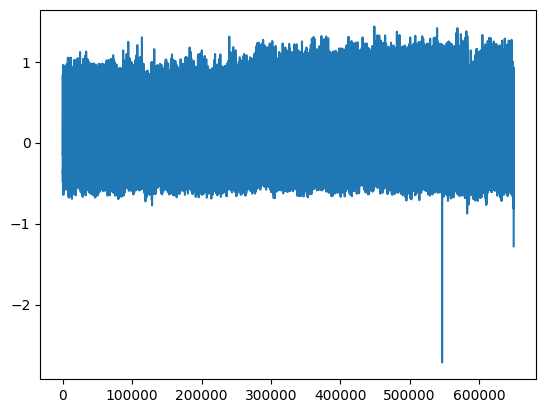

In [ ]:
import matplotlib.pyplot as plt

plt.plot(patient_record.p_signal[:,0:1])

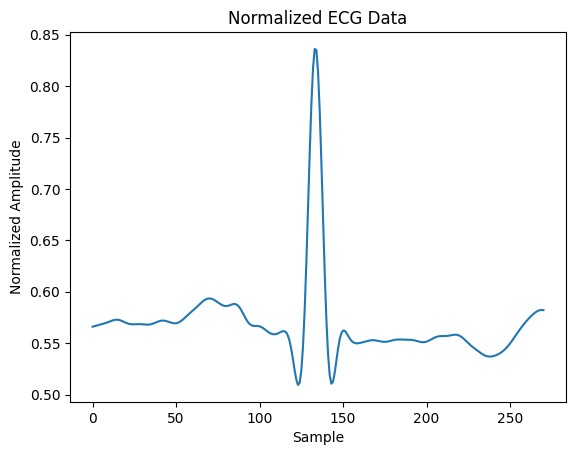

In [ ]:
import numpy as np
from scipy import signal

# Assuming 'patient_record.p_signal[:,0]' is your data
data = patient_record.p_signal[:,0]

# Filter signal
fs = patient_record.fs # 360Hz
numtaps = 51
f1, f2 = 0.5, 30
h = signal.firwin(numtaps, [f1, f2], pass_zero=False, window="hamming", fs=fs) # Band pass filter

fitlered_signal = signal.convolve(data, h)

# Normalize the data to the range [0, 1]
# normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data)) # for unfiltered data
normalized_data = (fitlered_signal - np.min(fitlered_signal)) / (np.max(fitlered_signal) - np.min(fitlered_signal))

anno = 2402
# Sample 0.3s before and 0.45s after the R peak
plt.plot(normalized_data[anno-int(0.3*fs): anno+int(0.45*fs)+1])
plt.title('Normalized ECG Data')
plt.xlabel('Sample')
plt.ylabel('Normalized Amplitude')
plt.show()

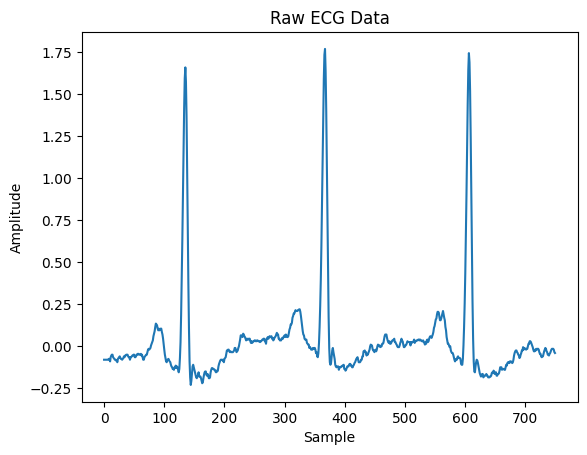

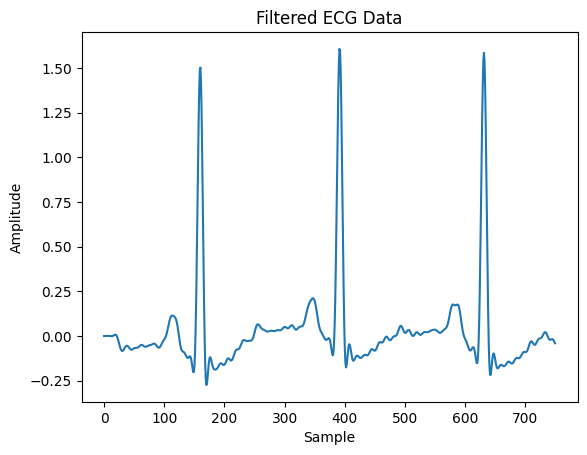

In [ ]:
fitlered_signal = signal.convolve(data, h)
plt.plot(data[:750])
plt.title('Raw ECG Data')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()
plt.plot(fitlered_signal[:750])
plt.title('Filtered ECG Data')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# Preprocessing data and sample signal around R peak

In [ ]:
import numpy as np
from scipy import signal

numtaps = 51
fs = 360  # 360Hz from the database
f1, f2 = 0.5, 30
h = signal.firwin(numtaps, [f1, f2], pass_zero=False, window='hamming', fs=fs) # Band pass filter
def filter_data(data):
  global h
  return np.convolve(data, h)


# Min-max normalizing
def normalize_data(data):
  return (data - np.min(data)) / (np.max(data) - np.min(data))


# Annotations for atr txt file
N = set(["N", "L", "R", "e", "j"])
S = set(["A", "a", "J", "S"])
V = set(["V", "E"])
F = set(["F"])
Q = set(["/", "f", "Q"])
def peak_segmentation(lead_II_data, atr_data):
  global fs, N, S, V, F, Q
  peaks = []
  classes = []
  end = len(lead_II_data)-1

  for item in atr_data:
    peak_index, heartbeat_type = int(item[0]), item[1]

    # Extract 0.3s before the R peak and 0.45s after the R peak
    peaks.append(lead_II_data[max(peak_index-int(0.3*fs), 0): min(peak_index+int(0.45*fs)+1, end)])

    # Grouping all into 5 classes according to Association for the Advancement
    # of Medical Instrumentation (AAMI) EC57 standard
    if heartbeat_type in N:
      heartbeat_type = 0
    elif heartbeat_type in S:
      heartbeat_type = 1
    elif heartbeat_type in V:
      heartbeat_type = 2
    elif heartbeat_type in F:
      heartbeat_type = 3
    else:  # Q type for unknown beats
      heartbeat_type = 4
    classes.append(heartbeat_type)

  return peaks[1:-1], classes[1:-1]  # Remove first and last element



In [ ]:
import numpy as np

peaks_data = []  # Extracted peaks
heartbeat_data = []  # type of heartbeat corresponding peak
lead_II_data = []
atr_data = []

# Read RECORDS file
with open(f"./{folder_name}/RECORDS", "r") as f:
    records = [line.strip() for line in f]

# For each record in records read patient ECG II Lead and its annotations and put in to data array
for record in records:
  patient_record = wfdb.rdrecord(f"./{folder_name}/{record}")
  # Read record annotation in atr text file
  with open(f"./{atr_folder_name}/atrs/{record}atr.txt", "r") as f: # Annotation for Patient
    atr = [line.strip().replace("\t", " ").split()[1:] for line in f]

  data = patient_record.p_signal[:,0] # Only use Lead II data
  annotations = atr

  # Filter the data and then normalize it
  filtered_data = filter_data(data)
  normalized_data = normalize_data(filter_data(data))

  # Extract peaks and their corresponding heartbeat_type
  peaks, classes = peak_segmentation(normalized_data, annotations)

  # Put data into array
  peaks_data.extend(peaks)
  heartbeat_data.extend(classes)
  lead_II_data.append(data)
  atr_data.append(atr)

In [ ]:
# Found degenerate sample
for i in range(len(peaks_data)):
  if peaks_data[i].shape != (271,):
    print(i)

55123


In [ ]:
# Remove degenerate sample
peaks_data.pop(55123)
heartbeat_data.pop(55123)

peaks_data = np.array(peaks_data)
heartbeat_data = np.array(heartbeat_data)
print(peaks_data.shape, heartbeat_data.shape)

(112502, 271) (112502,)


In [104]:
from collections import Counter

# Count the occurrences of each class
class_counts = Counter(heartbeat_data)

# Calculate the total number of samples
total_samples = len(heartbeat_data)

# Print the class distribution and percentage
for class_label, count in class_counts.items():
    percentage = (count / total_samples) * 100
    print(f"Class {class_label}: Count = {count}, Percentage = {percentage:.2f}%")


Class 0: Count = 90549, Percentage = 80.49%
Class 1: Count = 2779, Percentage = 2.47%
Class 2: Count = 7234, Percentage = 6.43%
Class 4: Count = 11138, Percentage = 9.90%
Class 3: Count = 802, Percentage = 0.71%


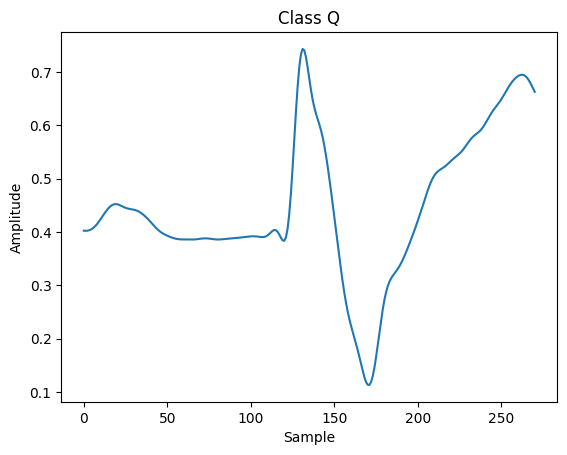

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create subplots for each class
num_classes = 5
classes_title = ["N", "S", "V", "F", "Q"]

for class_label in range(4,5):
    class_indices = np.where(heartbeat_data == class_label)[0]

    # Select a random sample from this class
    random_index_in_class = np.random.choice(class_indices)

    plt.plot(peaks_data[random_index_in_class])
    plt.title(f"Class {classes_title[class_label]}")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()


In [ ]:
mit_bih_data = np.hstack([peaks_data, np.expand_dims(heartbeat_data, 1)])

# Uncomment if want to save into csv file
np.savetxt("mit_bih_data.csv", mit_bih_data, delimiter=",")

In [ ]:
# prompt: read and display mit_bit_data.csv as numpy array using dataframe without try arugument

import pandas as pd
import numpy as np

# Load the data from the CSV file into a Pandas DataFrame
df = pd.read_csv('mit_bih_data.csv', header=None)

# Convert the DataFrame to a NumPy array
mit_bih_array = df.to_numpy()

# Display the NumPy array
mit_bih_array.shape

(112502, 272)